## Data Mining II Final Project ~ Jurgen Xhafaj

### Using Python to get predictions on soccer matches

#### * Total goals 0-2 or 3+
#### * 1 X 2
#### * Home team wins or not
#### * Which lineup works best (Home) or (Away)

In [1]:
import pandas as pd
import numpy as np
import keras
import matplotlib as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

df=pd.read_csv("edited match table.csv")
df.head()

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,IWA,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA
0,19694,19694,19694,2008/2009,1,9-Aug-08,489981,8596,8548,0,...,1.5,6.50,3.6,1.44,6.00,3.75,1.44,6.50,3.75,1.45
1,19696,19694,19694,2008/2009,1,9-Aug-08,489983,8597,10251,1,...,2.4,2.38,3.2,2.60,2.50,3.10,2.50,2.40,3.20,2.60
2,4776,4769,4769,2008/2009,1,9-Aug-08,483136,9851,8592,4,...,2.6,2.60,2.8,2.60,2.60,2.80,2.60,2.65,2.90,2.65
3,4774,4769,4769,2008/2009,1,9-Aug-08,483134,9829,9847,1,...,3.0,2.25,3.0,2.87,2.30,2.90,2.90,2.25,3.00,3.00
4,4778,4769,4769,2008/2009,1,9-Aug-08,483138,9873,9853,1,...,3.1,2.37,2.8,2.87,2.38,2.80,2.88,2.25,2.90,3.10


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020A81584588>]],
      dtype=object)

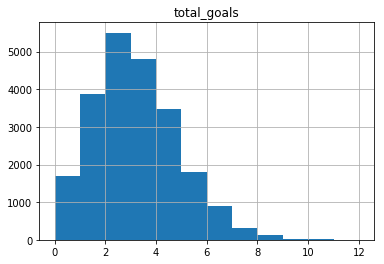

In [3]:
df['total_goals']=df['home_team_goal']+df['away_team_goal']
df.hist(column='total_goals', bins=12)

In [4]:
df['total_goals'].max()

12

In [5]:
df['total_goals'].min()

0

In [7]:
def betting(dl):
    if dl > 2.5: return 1
    else: return 0
df["output"] = df['total_goals'].map(betting)
df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,LBA,WHH,WHD,WHA,VCH,VCD,VCA,other_column,total_goals,output
0,19694,19694,19694,2008/2009,1,9-Aug-08,489981,8596,8548,0,...,1.44,6.00,3.75,1.44,6.50,3.75,1.45,1,1,0
1,19696,19694,19694,2008/2009,1,9-Aug-08,489983,8597,10251,1,...,2.60,2.50,3.10,2.50,2.40,3.20,2.60,1,1,0
2,4776,4769,4769,2008/2009,1,9-Aug-08,483136,9851,8592,4,...,2.60,2.60,2.80,2.60,2.65,2.90,2.65,8,8,1
3,4774,4769,4769,2008/2009,1,9-Aug-08,483134,9829,9847,1,...,2.87,2.30,2.90,2.90,2.25,3.00,3.00,1,1,0
4,4778,4769,4769,2008/2009,1,9-Aug-08,483138,9873,9853,1,...,2.87,2.38,2.80,2.88,2.25,2.90,3.10,1,1,0


In [8]:
x=np.array([df['stage'], df['B365H'], df['B365D'], df['B365A']])
y=np.array([df['output']])

In [9]:
#scale the units

scaler = MinMaxScaler()
x=scaler.fit_transform(x)

In [10]:
#new
new_df=df[['home_team_api_id','away_team_api_id','stage','B365H', 'B365D', 'B365A', 'output']]
new_df.head()

In [14]:
train, test = train_test_split(new_df, test_size=0.2)

x_train=train.iloc[:, 2:6]
x_test=test.iloc[:, 2:6]
y_train=train.iloc[:, 6]
y_test=test.iloc[:, 6]

In [16]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=4, activation='relu', kernel_initializer="uniform"))
    model.add(Dense(1, activation='sigmoid', kernel_initializer="uniform"))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=10, verbose=1)

# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(model, x_train, y_train, cv=kfold)
print(results.mean())

Epoch 1/10
16249/16249 [==============================] - 2s 136us/step - loss: 0.6903 - acc: 0.5114
Epoch 2/10
16249/16249 [==============================] - 2s 121us/step - loss: 0.6882 - acc: 0.5280
Epoch 3/10
16249/16249 [==============================] - 2s 123us/step - loss: 0.6875 - acc: 0.5389
Epoch 4/10
16249/16249 [==============================] - 2s 124us/step - loss: 0.6874 - acc: 0.5366
Epoch 5/10
16249/16249 [==============================] - 2s 121us/step - loss: 0.6872 - acc: 0.5378
Epoch 6/10
16249/16249 [==============================] - 2s 122us/step - loss: 0.6870 - acc: 0.5402
Epoch 7/10
16249/16249 [==============================] - 2s 123us/step - loss: 0.6868 - acc: 0.5422
Epoch 8/10
16249/16249 [==============================] - 2s 122us/step - loss: 0.6868 - acc: 0.5409
Epoch 9/10
16249/16249 [==============================] - 2s 124us/step - loss: 0.6868 - acc: 0.5413
Epoch 10/10
1806/1806 [==============================] - 0s 86us/step
Epoch 1/10
16249/1624

Epoch 8/10
16250/16250 [==============================] - 2s 128us/step - loss: 0.6879 - acc: 0.5363
Epoch 9/10
16250/16250 [==============================] - 2s 128us/step - loss: 0.6878 - acc: 0.5362
Epoch 10/10
1805/1805 [==============================] - 0s 131us/step
Epoch 1/10
16250/16250 [==============================] - 2s 150us/step - loss: 0.6903 - acc: 0.5195
Epoch 2/10
16250/16250 [==============================] - 2s 130us/step - loss: 0.6887 - acc: 0.5332
Epoch 3/10
16250/16250 [==============================] - 2s 128us/step - loss: 0.6885 - acc: 0.5340
Epoch 4/10
16250/16250 [==============================] - 2s 128us/step - loss: 0.6883 - acc: 0.5346
Epoch 5/10
16250/16250 [==============================] - 2s 128us/step - loss: 0.6879 - acc: 0.5363
Epoch 6/10
16250/16250 [==============================] - 2s 128us/step - loss: 0.6879 - acc: 0.5391
Epoch 7/10
16250/16250 [==============================] - 2s 126us/step - loss: 0.6875 - acc: 0.5407
Epoch 8/10
16250/162

In [19]:
#Grid Search
start = timer()

# define the grid search parameters
batch_size = [8,10,12]
epochs = [8,10,12]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=10)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
end = timer()
print(end - start)

Epoch 1/8
16249/16249 [==============================] - 3s 187us/step - loss: 0.6899 - acc: 0.5180
Epoch 2/8
16249/16249 [==============================] - 3s 163us/step - loss: 0.6883 - acc: 0.5301
Epoch 3/8
16249/16249 [==============================] - 3s 164us/step - loss: 0.6877 - acc: 0.5318
Epoch 4/8
16249/16249 [==============================] - 3s 163us/step - loss: 0.6878 - acc: 0.5323
Epoch 5/8
16249/16249 [==============================] - 3s 163us/step - loss: 0.6875 - acc: 0.5340
Epoch 6/8
16249/16249 [==============================] - 3s 163us/step - loss: 0.6875 - acc: 0.5362
Epoch 7/8
16249/16249 [==============================] - 3s 167us/step - loss: 0.6877 - acc: 0.5361
Epoch 8/8
16249/16249 [==============================] - 2s 98us/step
Epoch 1/8
16249/16249 [==============================] - 4s 217us/step - loss: 0.6908 - acc: 0.5157
Epoch 2/8
16249/16249 [==============================] - 3s 162us/step - loss: 0.6891 - acc: 0.5245
Epoch 3/8
16249/16249 [=======

16250/16250 [==============================] - 3s 181us/step - loss: 0.6881 - acc: 0.5326
Epoch 5/10
16250/16250 [==============================] - 3s 182us/step - loss: 0.6879 - acc: 0.5330
Epoch 6/10
16250/16250 [==============================] - 3s 182us/step - loss: 0.6878 - acc: 0.5375
Epoch 7/10
16250/16250 [==============================] - 3s 181us/step - loss: 0.6874 - acc: 0.5385
Epoch 8/10
16250/16250 [==============================] - 3s 190us/step - loss: 0.6874 - acc: 0.5395
Epoch 9/10
16250/16250 [==============================] - 3s 182us/step - loss: 0.6873 - acc: 0.5407
Epoch 10/10
16250/16250 [==============================] - 2s 108us/step
Epoch 1/10
16250/16250 [==============================] - 4s 234us/step - loss: 0.6901 - acc: 0.5167
Epoch 2/10
16250/16250 [==============================] - 3s 179us/step - loss: 0.6884 - acc: 0.5298
Epoch 3/10
16250/16250 [==============================] - 3s 183us/step - loss: 0.6883 - acc: 0.5312
Epoch 4/10
16250/16250 [=====

16250/16250 [==============================] - 3s 190us/step - loss: 0.6886 - acc: 0.5338
Epoch 3/12
16250/16250 [==============================] - 3s 190us/step - loss: 0.6881 - acc: 0.5369
Epoch 4/12
16250/16250 [==============================] - 3s 188us/step - loss: 0.6877 - acc: 0.5350
Epoch 5/12
16250/16250 [==============================] - 3s 191us/step - loss: 0.6880 - acc: 0.5350
Epoch 6/12
16250/16250 [==============================] - 3s 190us/step - loss: 0.6878 - acc: 0.5359
Epoch 7/12
16250/16250 [==============================] - 3s 190us/step - loss: 0.6877 - acc: 0.5319
Epoch 8/12
16250/16250 [==============================] - 3s 189us/step - loss: 0.6875 - acc: 0.5390
Epoch 9/12
16250/16250 [==============================] - 3s 190us/step - loss: 0.6876 - acc: 0.5386
Epoch 10/12
16250/16250 [==============================] - 3s 191us/step - loss: 0.6876 - acc: 0.5417
Epoch 11/12
16250/16250 [==============================] - 3s 193us/step - loss: 0.6877 - acc: 0.5373

16250/16250 [==============================] - 3s 167us/step - loss: 0.6887 - acc: 0.5293
Epoch 4/10
16250/16250 [==============================] - 3s 166us/step - loss: 0.6886 - acc: 0.5305
Epoch 5/10
16250/16250 [==============================] - 3s 166us/step - loss: 0.6884 - acc: 0.5325
Epoch 6/10
16250/16250 [==============================] - 3s 167us/step - loss: 0.6885 - acc: 0.5327
Epoch 7/10
16250/16250 [==============================] - 3s 165us/step - loss: 0.6883 - acc: 0.5338
Epoch 8/10
16250/16250 [==============================] - 3s 177us/step - loss: 0.6883 - acc: 0.5330
Epoch 9/10
16250/16250 [==============================] - 3s 182us/step - loss: 0.6883 - acc: 0.5351
Epoch 10/10
16250/16250 [==============================] - 2s 95us/step
Epoch 1/10
16250/16250 [==============================] - 4s 255us/step - loss: 0.6907 - acc: 0.5158
Epoch 2/10
16250/16250 [==============================] - 2s 152us/step - loss: 0.6890 - acc: 0.5258
Epoch 3/10
16250/16250 [======

Epoch 3/12
16250/16250 [==============================] - 3s 158us/step - loss: 0.6880 - acc: 0.5309
Epoch 4/12
16250/16250 [==============================] - 3s 158us/step - loss: 0.6877 - acc: 0.5361
Epoch 5/12
16250/16250 [==============================] - 3s 159us/step - loss: 0.6879 - acc: 0.5351
Epoch 6/12
16250/16250 [==============================] - 3s 160us/step - loss: 0.6876 - acc: 0.5358
Epoch 7/12
16250/16250 [==============================] - 3s 158us/step - loss: 0.6877 - acc: 0.5345
Epoch 8/12
16250/16250 [==============================] - 3s 158us/step - loss: 0.6877 - acc: 0.5356
Epoch 9/12
16250/16250 [==============================] - 3s 170us/step - loss: 0.6878 - acc: 0.5354
Epoch 10/12
16250/16250 [==============================] - 3s 187us/step - loss: 0.6877 - acc: 0.5394
Epoch 11/12
16250/16250 [==============================] - 3s 174us/step - loss: 0.6877 - acc: 0.5346
Epoch 12/12
16250/16250 [==============================] - 2s 109us/step
Epoch 1/12
16250

16249/16249 [==============================] - 2s 153us/step - loss: 0.6883 - acc: 0.5367
Epoch 4/10
16249/16249 [==============================] - 3s 195us/step - loss: 0.6882 - acc: 0.5331
Epoch 5/10
16249/16249 [==============================] - 2s 145us/step - loss: 0.6879 - acc: 0.5366
Epoch 6/10
16249/16249 [==============================] - 2s 144us/step - loss: 0.6878 - acc: 0.5405
Epoch 7/10
16249/16249 [==============================] - 2s 145us/step - loss: 0.6877 - acc: 0.5359
Epoch 8/10
16249/16249 [==============================] - 3s 165us/step - loss: 0.6878 - acc: 0.5422
Epoch 9/10
16249/16249 [==============================] - 3s 154us/step - loss: 0.6874 - acc: 0.5395
Epoch 10/10
16249/16249 [==============================] - 2s 98us/step
Epoch 1/10
16250/16250 [==============================] - 5s 323us/step - loss: 0.6912 - acc: 0.5087
Epoch 2/10
16250/16250 [==============================] - 3s 158us/step - loss: 0.6890 - acc: 0.5229
Epoch 3/10
16250/16250 [======

16250/16250 [==============================] - 3s 167us/step - loss: 0.6880 - acc: 0.5366
Epoch 5/12
16250/16250 [==============================] - 3s 166us/step - loss: 0.6878 - acc: 0.5364
Epoch 6/12
16250/16250 [==============================] - 3s 159us/step - loss: 0.6877 - acc: 0.5385
Epoch 7/12
16250/16250 [==============================] - 3s 166us/step - loss: 0.6876 - acc: 0.5403
Epoch 8/12
16250/16250 [==============================] - 3s 157us/step - loss: 0.6875 - acc: 0.5368
Epoch 9/12
16250/16250 [==============================] - 3s 161us/step - loss: 0.6876 - acc: 0.5346
Epoch 10/12
16250/16250 [==============================] - 3s 163us/step - loss: 0.6876 - acc: 0.5367
Epoch 11/12
16250/16250 [==============================] - 3s 160us/step - loss: 0.6874 - acc: 0.5369
Epoch 12/12
16250/16250 [==============================] - 2s 107us/step
Epoch 1/12
16250/16250 [==============================] - 6s 347us/step - loss: 0.6901 - acc: 0.5172
Epoch 2/12
16250/16250 [===

In [ ]:
# from that, we decide to use batch_size=8, epochs=10

In [ ]:
# now, random forest

In [89]:
df['total']=df['home_team_goal']+df['away_team_goal']

def betting(dl):
    if dl > 2.5: return 1
    else: return 0
df["output"] = df['total_goals'].map(betting)

new_df=df[['stage','B365H', 'B365D', 'B365A', 'output']]
new_df.head()



,stage,B365H,B365D,B365A,output
0,1,6.5,4.0,1.50,0
1,1,2.4,3.2,2.62,0
2,1,2.7,3.0,2.80,1
3,1,2.4,3.1,3.10,0
4,1,2.4,3.1,3.10,0


In [90]:
start=timer()

X=new_df.iloc[:,0:4]
Y=new_df.iloc[:,4]

scaler = MinMaxScaler()
X=scaler.fit_transform(X)


seed = 7
num_trees = 5
max_features = 4
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results = model_selection.cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

end=timer()
print(end-start)



0.5127832412422946
2.3470050868454564


In [91]:
#Grid Search
start = timer()

# define the grid search parameters
n_estimators=[6,7,8,9,10,11,12,13,14,15]
param_grid = dict(n_estimators=n_estimators)

seed=7
num_trees=5

model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=10)
grid_result = grid.fit(X,Y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
end = timer()
print(end - start)

Best: 0.514733 using {'n_estimators': 7}
0.507643 (0.010870) with: {'n_estimators': 6}
0.514733 (0.011811) with: {'n_estimators': 7}
0.509194 (0.013246) with: {'n_estimators': 8}
0.510878 (0.011737) with: {'n_estimators': 9}
0.510878 (0.012263) with: {'n_estimators': 10}
0.513403 (0.012899) with: {'n_estimators': 11}
0.507422 (0.014542) with: {'n_estimators': 12}
0.511055 (0.014030) with: {'n_estimators': 13}
0.513226 (0.013342) with: {'n_estimators': 14}
0.513137 (0.012044) with: {'n_estimators': 15}
52.35487234368338


## here we try to predict 1 X 2

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026EBC14CC18>]],
      dtype=object)

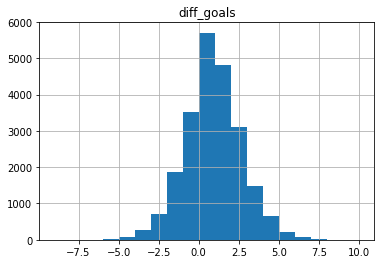

In [23]:
df['diff_goals']=df['home_team_goal']-df['away_team_goal']
df.hist(column='diff_goals', bins=19)


In [21]:
df['diff_goals'].max()

10

In [22]:
df['diff_goals'].min()

-9

In [29]:
# 1 means home team wins, 2 means it's a tie, 3 means away team wins

def betting(dl):
    if dl > 0.5: return 1
    elif dl==0: return 2
    else: return 3
df["result"] = df['diff_goals'].map(betting)
df.head()

x=np.array([df['stage'], df['B365H'], df['B365D'], df['B365A']])
y=np.array([df['result']])


In [30]:
#scale the units

scaler = MinMaxScaler()
x=scaler.fit_transform(x)

In [31]:
new_df=df[['home_team_api_id','away_team_api_id','stage','B365H', 'B365D', 'B365A', 'result']]
new_df.head()

,home_team_api_id,away_team_api_id,stage,B365H,B365D,B365A,result
0,8596,8548,1,6.5,4.0,1.50,3
1,8597,10251,1,2.4,3.2,2.62,1
2,9851,8592,1,2.7,3.0,2.80,2
3,9829,9847,1,2.4,3.1,3.10,1
4,9873,9853,1,2.4,3.1,3.10,1


In [32]:
train, test = train_test_split(new_df, test_size=0.2)
x_train=train.iloc[:, 2:6]
x_test=test.iloc[:, 2:6]
y_train=train.iloc[:, 6]
y_test=test.iloc[:, 6]

In [39]:
start=timer()

def create_model(optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=4, activation='relu', kernel_initializer="uniform"))
    model.add(Dense(1, activation='sigmoid', kernel_initializer="uniform"))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=8, verbose=1)

# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(model, x_train, y_train, cv=kfold)
print(results.mean())

end = timer()
print (end-start)

Epoch 1/10
16248/16248 [==============================] - 9s 573us/step - loss: -0.0370 - acc: 0.3227
Epoch 2/10
16248/16248 [==============================] - 5s 306us/step - loss: -0.5364 - acc: 0.3587
Epoch 3/10
16248/16248 [==============================] - 5s 300us/step - loss: -0.6431 - acc: 0.3474
Epoch 4/10
16248/16248 [==============================] - 5s 319us/step - loss: -0.6942 - acc: 0.3490
Epoch 5/10
16248/16248 [==============================] - 5s 313us/step - loss: -0.7187 - acc: 0.3474
Epoch 6/10
16248/16248 [==============================] - 5s 305us/step - loss: -0.7350 - acc: 0.3481
Epoch 7/10
16248/16248 [==============================] - 5s 308us/step - loss: -0.7452 - acc: 0.3464
Epoch 8/10
16248/16248 [==============================] - 5s 305us/step - loss: -0.7502 - acc: 0.3448
Epoch 9/10
16248/16248 [==============================] - 5s 293us/step - loss: -0.7545 - acc: 0.3472
Epoch 10/10
1807/1807 [==============================] - 2s 1ms/step
Epoch 1/10
16

In [41]:
#Grid Search
start = timer()

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=10)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
end = timer()
print(end - start)



Epoch 1/10
16249/16249 [==============================] - 10s 607us/step - loss: -0.2950 - acc: 0.3425
Epoch 2/10
16249/16249 [==============================] - 5s 311us/step - loss: -0.6013 - acc: 0.3502
Epoch 3/10
16249/16249 [==============================] - 5s 314us/step - loss: -0.6443 - acc: 0.3421
Epoch 4/10
16249/16249 [==============================] - 5s 325us/step - loss: -0.6717 - acc: 0.3370
Epoch 5/10
16249/16249 [==============================] - 5s 316us/step - loss: -0.6671 - acc: 0.3360
Epoch 6/10
16249/16249 [==============================] - 5s 317us/step - loss: -0.6883 - acc: 0.3333
Epoch 7/10
16249/16249 [==============================] - 5s 319us/step - loss: -0.6737 - acc: 0.3380
Epoch 8/10
16249/16249 [==============================] - 5s 314us/step - loss: -0.6835 - acc: 0.3367
Epoch 9/10
16249/16249 [==============================] - 5s 314us/step - loss: -0.6807 - acc: 0.3351
Epoch 10/10
16249/16249 [==============================] - 4s 223us/step
Epoch 1/

16250/16250 [==============================] - 6s 340us/step - loss: -0.6417 - acc: 0.3423
Epoch 4/10
16250/16250 [==============================] - 5s 338us/step - loss: -0.6270 - acc: 0.3424
Epoch 5/10
16250/16250 [==============================] - 5s 337us/step - loss: -0.6346 - acc: 0.3407
Epoch 6/10
16250/16250 [==============================] - 6s 339us/step - loss: -0.6718 - acc: 0.3365
Epoch 7/10
16250/16250 [==============================] - 6s 339us/step - loss: -0.6893 - acc: 0.3362
Epoch 8/10
16250/16250 [==============================] - 6s 367us/step - loss: -0.6487 - acc: 0.3346
Epoch 9/10
16250/16250 [==============================] - 6s 339us/step - loss: -0.7106 - acc: 0.3356
Epoch 10/10
16250/16250 [==============================] - 4s 244us/step
Epoch 1/10
16250/16250 [==============================] - 10s 641us/step - loss: -0.3049 - acc: 0.3465
Epoch 2/10
16250/16250 [==============================] - 5s 338us/step - loss: -0.6274 - acc: 0.3498
Epoch 3/10
16250/16

16249/16249 [==============================] - 6s 342us/step - loss: -0.7125 - acc: 0.3532
Epoch 6/10
16249/16249 [==============================] - 6s 345us/step - loss: -0.7384 - acc: 0.3517
Epoch 7/10
16249/16249 [==============================] - 6s 345us/step - loss: -0.7485 - acc: 0.3502
Epoch 8/10
16249/16249 [==============================] - 6s 343us/step - loss: -0.7660 - acc: 0.3526
Epoch 9/10
16249/16249 [==============================] - 6s 346us/step - loss: -0.7731 - acc: 0.3509
Epoch 10/10
16249/16249 [==============================] - 4s 246us/step
Epoch 1/10
16250/16250 [==============================] - 11s 671us/step - loss: -0.0797 - acc: 0.3287
Epoch 2/10
16250/16250 [==============================] - 6s 352us/step - loss: -0.6180 - acc: 0.3670
Epoch 3/10
16250/16250 [==============================] - 6s 352us/step - loss: -0.7014 - acc: 0.3604
Epoch 4/10
16250/16250 [==============================] - 6s 352us/step - loss: -0.7413 - acc: 0.3594
Epoch 5/10
16250/16

16250/16250 [==============================] - 6s 362us/step - loss: -0.4602 - acc: 0.3486
Epoch 10/10
16250/16250 [==============================] - 4s 258us/step
Epoch 1/10
16250/16250 [==============================] - 11s 698us/step - loss: 0.1294 - acc: 0.3134
Epoch 2/10
16250/16250 [==============================] - 6s 355us/step - loss: -0.1572 - acc: 0.3367
Epoch 3/10
16250/16250 [==============================] - 6s 356us/step - loss: -0.2724 - acc: 0.3454
Epoch 4/10
16250/16250 [==============================] - 6s 357us/step - loss: -0.3318 - acc: 0.3487
Epoch 5/10
16250/16250 [==============================] - 6s 357us/step - loss: -0.3712 - acc: 0.3483
Epoch 6/10
16250/16250 [==============================] - 6s 358us/step - loss: -0.3965 - acc: 0.3474
Epoch 7/10
16250/16250 [==============================] - 6s 359us/step - loss: -0.4144 - acc: 0.3482
Epoch 8/10
16250/16250 [==============================] - 6s 358us/step - loss: -0.4284 - acc: 0.3483
Epoch 9/10
16250/162

16249/16249 [==============================] - 12s 729us/step - loss: -0.2569 - acc: 0.3384
Epoch 2/10
16249/16249 [==============================] - 6s 356us/step - loss: -0.5620 - acc: 0.3503
Epoch 3/10
16249/16249 [==============================] - 6s 355us/step - loss: -0.6387 - acc: 0.3495
Epoch 4/10
16249/16249 [==============================] - 6s 364us/step - loss: -0.6859 - acc: 0.3522
Epoch 5/10
16249/16249 [==============================] - 6s 355us/step - loss: -0.7062 - acc: 0.3534
Epoch 6/10
16249/16249 [==============================] - 6s 358us/step - loss: -0.7221 - acc: 0.3511
Epoch 7/10
16249/16249 [==============================] - 6s 358us/step - loss: -0.7256 - acc: 0.3554
Epoch 8/10
16249/16249 [==============================] - 6s 356us/step - loss: -0.7315 - acc: 0.3542
Epoch 9/10
16249/16249 [==============================] - 6s 356us/step - loss: -0.7380 - acc: 0.3538
Epoch 10/10
16249/16249 [==============================] - 4s 247us/step
Epoch 1/10
16249/16

In [ ]:
# from now on, we will use Adagrad optimizer since it gave better 
# results than adam and other optimizers.

In [52]:
train, test = train_test_split(new_df, test_size=0.2)
x_train=train.iloc[:, 2:6]
x_test=test.iloc[:, 2:6]
y_train=train.iloc[:, 6]
y_test=test.iloc[:, 6]

In [73]:
start=timer()

def create_model(optimizer='Adagrad', activation='relu', hidden_layers=1):
    # create model
    model = Sequential()
    model.add(Dense(5, input_dim=4, activation='relu', kernel_initializer="uniform"))
    model.add(Dense(8, activation='relu', kernel_initializer="uniform"))

    for i in range(hidden_layers):
        #add one hidden layer
        model.add(Dense(1, activation=activation))
        
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=8, verbose=1)

#evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
results = cross_val_score(model, x_train, y_train, cv=kfold)
print(results.mean())

end = timer()
print (end-start)

Epoch 1/5
12035/12035 [==============================] - 11s 949us/step - loss: 13.3498 - acc: 0.4600
Epoch 2/5
12035/12035 [==============================] - 5s 436us/step - loss: 13.3498 - acc: 0.4600
Epoch 3/5
12035/12035 [==============================] - 5s 423us/step - loss: 13.3498 - acc: 0.4600
Epoch 4/5
12035/12035 [==============================] - 5s 425us/step - loss: 13.3498 - acc: 0.4600
Epoch 5/5
6020/6020 [==============================] - 5s 765us/step
Epoch 1/5
12037/12037 [==============================] - 11s 918us/step - loss: 0.2053 - acc: 0.3230
Epoch 2/5
12037/12037 [==============================] - 4s 365us/step - loss: -0.0097 - acc: 0.3016
Epoch 3/5
12037/12037 [==============================] - 5s 387us/step - loss: -0.2447 - acc: 0.3247
Epoch 4/5
12037/12037 [==============================] - 5s 381us/step - loss: -0.2753 - acc: 0.3370
Epoch 5/5
6018/6018 [==============================] - 5s 772us/step
Epoch 1/5
12038/12038 [==============================

In [ ]:
# For the block above, my first try was layer1 activation=relu and layer2 activation=sigmoid.
# It seems like doing relu for layer 1 and sigmoid for layer 2 gave lower results (33%) than using relu on both(37%), so
# I decided to use relu on both layers and proceeded with that.

In [74]:
#Grid Search
start = timer()

# define the grid search parameters
hidden_layers=[1,2,3]
param_grid = dict(hidden_layers=hidden_layers)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=10)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
end = timer()
print(end - start)

Epoch 1/5
16249/16249 [==============================] - 13s 819us/step - loss: 13.3228 - acc: 0.4599
Epoch 2/5
16249/16249 [==============================] - 7s 420us/step - loss: 13.3228 - acc: 0.4599
Epoch 3/5
16249/16249 [==============================] - 7s 424us/step - loss: 13.3228 - acc: 0.4599
Epoch 4/5
16249/16249 [==============================] - 7s 422us/step - loss: 13.3228 - acc: 0.4599
Epoch 5/5
16249/16249 [==============================] - 5s 311us/step
Epoch 1/5
16249/16249 [==============================] - 13s 808us/step - loss: 13.3962 - acc: 0.4583
Epoch 2/5
16249/16249 [==============================] - 6s 384us/step - loss: 13.3962 - acc: 0.4583
Epoch 3/5
16249/16249 [==============================] - 8s 492us/step - loss: 13.3962 - acc: 0.4583
Epoch 4/5
16249/16249 [==============================] - 7s 448us/step - loss: 13.3962 - acc: 0.4583
Epoch 5/5
16249/16249 [==============================] - 5s 335us/step
Epoch 1/5
16249/16249 [=========================

16249/16249 [==============================] - 7s 425us/step - loss: -0.0723 - acc: 0.3104
Epoch 3/5
16249/16249 [==============================] - 7s 408us/step - loss: -0.1061 - acc: 0.3123
Epoch 4/5
16249/16249 [==============================] - 6s 396us/step - loss: -0.1858 - acc: 0.3113
Epoch 5/5
16249/16249 [==============================] - 5s 316us/step
Epoch 1/5
16249/16249 [==============================] - 14s 878us/step - loss: 0.5714 - acc: 0.3114
Epoch 2/5
16249/16249 [==============================] - 7s 451us/step - loss: 0.1445 - acc: 0.3291
Epoch 3/5
16249/16249 [==============================] - 7s 441us/step - loss: 0.4525 - acc: 0.3971
Epoch 4/5
16249/16249 [==============================] - 7s 439us/step - loss: 0.6112 - acc: 0.4251
Epoch 5/5
16249/16249 [==============================] - 5s 331us/step
Epoch 1/5
16250/16250 [==============================] - 14s 865us/step - loss: 0.9306 - acc: 0.3492
Epoch 2/5
16250/16250 [==============================] - 7s 442

16250/16250 [==============================] - 8s 467us/step - loss: 13.3349 - acc: 0.4600
Epoch 4/5
16250/16250 [==============================] - 7s 460us/step - loss: 13.3349 - acc: 0.4600
Epoch 5/5
16250/16250 [==============================] - 5s 331us/step
Epoch 1/5
16250/16250 [==============================] - 15s 948us/step - loss: 13.3795 - acc: 0.4589
Epoch 2/5
16250/16250 [==============================] - 8s 471us/step - loss: 13.3795 - acc: 0.4589
Epoch 3/5
16250/16250 [==============================] - 8s 464us/step - loss: 13.3795 - acc: 0.4589
Epoch 4/5
16250/16250 [==============================] - 8s 478us/step - loss: 13.3795 - acc: 0.4589
Epoch 5/5
16250/16250 [==============================] - 6s 340us/step
Epoch 1/5
16250/16250 [==============================] - 15s 916us/step - loss: 13.2793 - acc: 0.4633
Epoch 2/5
16250/16250 [==============================] - 8s 471us/step - loss: 13.2793 - acc: 0.4633
Epoch 3/5
16250/16250 [==============================] - 7

In [ ]:
# since we found 3 layers was optimal out of the options 1,2,3, let us perform
# another grid search, this time with 4 or 5 hidden layers

In [77]:
#Grid Search
start = timer()

# define the grid search parameters
hidden_layers=[6,7]
param_grid = dict(hidden_layers=hidden_layers)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
end = timer()
print(end - start)

Epoch 1/5
12036/12036 [==============================] - 15s 1ms/step - loss: 13.3594 - acc: 0.4580
Epoch 2/5
12036/12036 [==============================] - 6s 531us/step - loss: 13.3594 - acc: 0.4580
Epoch 3/5
12036/12036 [==============================] - 6s 533us/step - loss: 13.3594 - acc: 0.4580
Epoch 4/5
12036/12036 [==============================] - 7s 563us/step - loss: 13.3594 - acc: 0.4580
Epoch 5/5
12036/12036 [==============================] - 4s 366us/step
Epoch 1/5
12037/12037 [==============================] - 15s 1ms/step - loss: 13.3784 - acc: 0.4597
Epoch 2/5
12037/12037 [==============================] - 6s 508us/step - loss: 13.3784 - acc: 0.4597
Epoch 3/5
12037/12037 [==============================] - 6s 496us/step - loss: 13.3784 - acc: 0.4597
Epoch 4/5
12037/12037 [==============================] - 6s 497us/step - loss: 13.3784 - acc: 0.4597
Epoch 5/5
12037/12037 [==============================] - 5s 399us/step
Epoch 1/5
12037/12037 [=============================

In [ ]:
# seems like we got the same accuracy for 6 layers as we did for 5 and 7 as well, so we might as well keep only 5 hidden layers.

In [81]:
#below, we use random forest classifier to predict 1x2

In [83]:
# predict who wins, using random forest


df['diff_goals']=df['home_team_goal']-df['away_team_goal']

def betting(dl):
    if dl > 0.5: return 1
    elif dl==0: return 2
    else: return 3
df["result"] = df['diff_goals'].map(betting)

new_df=df[['stage','B365H', 'B365D', 'B365A', 'result']]
new_df.head()

,stage,B365H,B365D,B365A,result
0,1,6.5,4.0,1.50,3
1,1,2.4,3.2,2.62,1
2,1,2.7,3.0,2.80,2
3,1,2.4,3.1,3.10,1
4,1,2.4,3.1,3.10,1


In [84]:
start=timer()

X=new_df.iloc[:,0:4]
Y=new_df.iloc[:,4]

scaler = MinMaxScaler()
X=scaler.fit_transform(X)


seed = 7
num_trees = 5
max_features = 4
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results = model_selection.cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

end=timer()
print(end-start)

0.44126899050662394
2.2103511528439412


In [85]:
#Grid Search
start = timer()

# define the grid search parameters
n_estimators=[6,7,8,9,10,11,12,13,14,15]
param_grid = dict(n_estimators=n_estimators)

seed=7
num_trees=5

model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=10)
grid_result = grid.fit(X,Y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
end = timer()
print(end - start)

Best: 0.443662 using {'n_estimators': 12}
0.440073 (0.008037) with: {'n_estimators': 6}
0.439231 (0.010125) with: {'n_estimators': 7}
0.440294 (0.008165) with: {'n_estimators': 8}
0.441402 (0.009930) with: {'n_estimators': 9}
0.443086 (0.008100) with: {'n_estimators': 10}
0.439851 (0.010180) with: {'n_estimators': 11}
0.443662 (0.009230) with: {'n_estimators': 12}
0.440206 (0.008288) with: {'n_estimators': 13}
0.440161 (0.009841) with: {'n_estimators': 14}
0.439674 (0.009405) with: {'n_estimators': 15}
52.569825169997785


In [ ]:
# next, we try to predict whether the home team will win or not (4 features)

In [93]:
start=timer()

df = pandas.read_csv('edited match table.csv')
df['other_column']=df['home_team_goal']-df['away_team_goal']
def betting(dl):
    if dl > 0.5: return 1
    else: return 0
df["Code"] = df['other_column'].map(betting)

home_wins=df[['stage','B365H', 'B365D', 'B365A', 'Code']]


X=home_wins.iloc[:,0:4]
Y=home_wins.iloc[:,4]

seed = 7
num_trees = 5
max_features = 4
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results = model_selection.cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

end=timer()
print(end-start)

0.5835883712453296
2.294004668852722


In [94]:
#Grid Search
start = timer()

# define the grid search parameters
n_estimators=[6,7,8,9,10,11,12,13,14,15]
param_grid = dict(n_estimators=n_estimators)

seed=7
num_trees=5

model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=10)
grid_result = grid.fit(X,Y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
end = timer()
print(end - start)

Best: 0.586512 using {'n_estimators': 8}
0.581683 (0.007800) with: {'n_estimators': 6}
0.581594 (0.007710) with: {'n_estimators': 7}
0.586512 (0.009369) with: {'n_estimators': 8}
0.583632 (0.011125) with: {'n_estimators': 9}
0.582170 (0.009601) with: {'n_estimators': 10}
0.583544 (0.009887) with: {'n_estimators': 11}
0.584652 (0.007727) with: {'n_estimators': 12}
0.582436 (0.007810) with: {'n_estimators': 13}
0.583677 (0.009610) with: {'n_estimators': 14}
0.583411 (0.008471) with: {'n_estimators': 15}
50.83285764668835


In [ ]:
# below we only use 3 features for the prediction (excluding Stage)

In [96]:
start=timer()
df = pandas.read_csv('edited match table.csv')
df['other_column']=df['home_team_goal']-df['away_team_goal']
def betting(dl):
    if dl > 0.5: return 1
    else: return 0
df["Code"] = df['other_column'].map(betting)

new_df=df[['B365H', 'B365D', 'B365A', 'Code']]

X=new_df.iloc[:,0:3]
Y=new_df.iloc[:,3]

seed = 7
num_trees = 10
max_features = 3
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results = model_selection.cross_val_score(model, X, Y, cv=kfold)
print(results.mean())
end=timer()
print(end-start)

0.6239523727599242
2.6925565225828905


In [97]:
#Grid Search
start = timer()

# define the grid search parameters
n_estimators=[6,7,8,9,10,11,12,13,14,15]
param_grid = dict(n_estimators=n_estimators)

seed=7
num_trees = 10
max_features = 3

model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=10)
grid_result = grid.fit(X,Y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
end = timer()
print(end - start)

Best: 0.626479 using {'n_estimators': 15}
0.622491 (0.013733) with: {'n_estimators': 6}
0.623820 (0.011736) with: {'n_estimators': 7}
0.624396 (0.010155) with: {'n_estimators': 8}
0.624308 (0.012236) with: {'n_estimators': 9}
0.624441 (0.013517) with: {'n_estimators': 10}
0.624928 (0.012917) with: {'n_estimators': 11}
0.622934 (0.015465) with: {'n_estimators': 12}
0.624884 (0.014080) with: {'n_estimators': 13}
0.624441 (0.013400) with: {'n_estimators': 14}
0.626479 (0.015335) with: {'n_estimators': 15}
31.65665469907981


In [98]:
#Grid Search
start = timer()

# define the grid search parameters
n_estimators=[20,25,30]
param_grid = dict(n_estimators=n_estimators)

seed=7
num_trees = 10
max_features = 3

model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=10)
grid_result = grid.fit(X,Y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
end = timer()
print(end - start)

Best: 0.627143 using {'n_estimators': 25}
0.624529 (0.014747) with: {'n_estimators': 20}
0.627143 (0.014655) with: {'n_estimators': 25}
0.626124 (0.015483) with: {'n_estimators': 30}
22.409402920737193


In [101]:
# AdaBoost Classification
start=timer()
seed = 7
num_trees = 25
max_features = 3

kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X, Y, cv=kfold)
print(results.mean())
end=timer()
print(end-start)

0.6514696790442344
3.7498843050452706


In [102]:
#Grid Search
start = timer()

# define the grid search parameters
n_estimators=[15,20,25,30,35]
param_grid = dict(n_estimators=n_estimators)

seed=7
num_trees = 25
max_features = 3

model = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=10)
grid_result = grid.fit(X,Y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
end = timer()
print(end - start)

Best: 0.651469 using {'n_estimators': 15}
0.651469 (0.009735) with: {'n_estimators': 15}
0.651469 (0.009735) with: {'n_estimators': 20}
0.651469 (0.009735) with: {'n_estimators': 25}
0.651469 (0.009735) with: {'n_estimators': 30}
0.651469 (0.009735) with: {'n_estimators': 35}
25.607447022906854


In [105]:
# Stochastic Gradient Boosting Classification
start=timer()
seed = 7
num_trees = 15
max_features = 3

kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X, Y, cv=kfold)
print(results.mean())
end=timer()
print(end-start)

0.6510708410712771
2.1135294051782694


In [107]:
#Grid Search
start = timer()

# define the grid search parameters
n_estimators=[10,15,20,25,30,35]
param_grid = dict(n_estimators=n_estimators)

seed=7
num_trees = 25
max_features = 3

model = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=10)
grid_result = grid.fit(X,Y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
end = timer()
print(end - start)

Best: 0.651956 using {'n_estimators': 35}
0.651469 (0.009735) with: {'n_estimators': 10}
0.650317 (0.008261) with: {'n_estimators': 15}
0.650405 (0.008209) with: {'n_estimators': 20}
0.651070 (0.008579) with: {'n_estimators': 25}
0.651912 (0.008989) with: {'n_estimators': 30}
0.651956 (0.009491) with: {'n_estimators': 35}
17.342872724355402


In [108]:
#Grid Search
start = timer()

# define the grid search parameters
n_estimators=[35, 37, 39, 41, 43, 45]
param_grid = dict(n_estimators=n_estimators)

seed=7
num_trees = 25
max_features = 3

model = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=10)
grid_result = grid.fit(X,Y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
end = timer()
print(end - start)

Best: 0.652621 using {'n_estimators': 41}
0.651956 (0.009491) with: {'n_estimators': 35}
0.652133 (0.009549) with: {'n_estimators': 37}
0.652399 (0.009394) with: {'n_estimators': 39}
0.652621 (0.008831) with: {'n_estimators': 41}
0.652399 (0.008583) with: {'n_estimators': 43}
0.652532 (0.008692) with: {'n_estimators': 45}
28.64511132840198


In [109]:
# Voting Ensemble for Classification
start=timer()

seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)

# create the sub models
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier()
estimators.append(('cart', model2))
model3 = SVC()
estimators.append(('svm', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X, Y, cv=kfold)
print(results.mean())

end=timer()
print(end-start)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

0.6529759856647719
282.7305002687099


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### predicting the best formation


In [ ]:
# there is an issue linking the tables together. There is no common identifier for the matches / teams.
# Even if you connect on dates,you will not be able to know which team is which,because the dates and scores are only 
# provided on one table (and it's the same table that has both). The other table has other numbers identifying the same team.